   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 9.7 MB/s eta 0:00:00
Please upload a PCAP file for analysis (e.g., sample.pcap):


Saving Take Home Test.pcap to Take Home Test.pcap
Extracted Features from PCAP:


,src_ip,dst_ip,src_port,dst_port,proto,pkt_len
0,192.168.138.158,192.168.138.2,60078,53,17,137
1,192.168.138.2,192.168.138.158,53,60078,17,153
2,192.168.138.158,192.168.138.2,65315,53,17,136
3,192.168.138.158,192.168.138.2,50683,53,17,135
4,192.168.138.2,192.168.138.158,53,65315,17,152


Model Accuracy: 40.00%

🚨 ALERT: Suspicious Activities Detected! 🚨
Details of detected anomalies:


,src_ip,dst_ip,src_port,dst_port,proto,pkt_len
9,192.168.138.2,192.168.138.158,53,61720,17,86


Anomalies logged to 'anomaly_log.csv'. Download it from Colab's file panel.


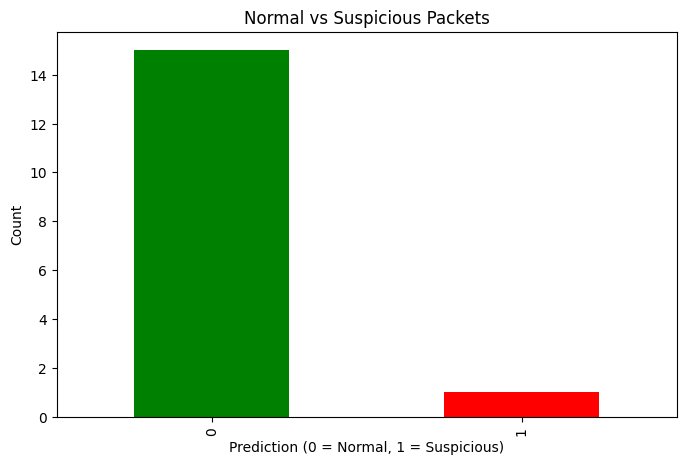

In [1]:
# Install required libraries
!pip install scapy pandas scikit-learn

# Import libraries
import pandas as pd
from scapy.all import rdpcap, IP, TCP, UDP
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

# Step 1: Upload a PCAP file (e.g., from Wireshark or a dataset)
from google.colab import files
print("Please upload a PCAP file for analysis (e.g., sample.pcap):")
uploaded = files.upload()

# Load the PCAP file (assumes one file is uploaded)
pcap_file = list(uploaded.keys())[0]
packets = rdpcap(pcap_file)

# Step 2: Extract features from packets
def extract_features(packets):
    features = []
    for pkt in packets:
        if IP in pkt:
            # Basic features: src IP, dst IP, ports, protocol, packet length
            src_ip = pkt[IP].src
            dst_ip = pkt[IP].dst
            pkt_len = len(pkt)
            src_port = dst_port = proto = 0

            if TCP in pkt:
                src_port = pkt[TCP].sport
                dst_port = pkt[TCP].dport
                proto = 6  # TCP
            elif UDP in pkt:
                src_port = pkt[UDP].sport
                dst_port = pkt[UDP].dport
                proto = 17  # UDP

            features.append([src_ip, dst_ip, src_port, dst_port, proto, pkt_len])

    return pd.DataFrame(features, columns=['src_ip', 'dst_ip', 'src_port', 'dst_port', 'proto', 'pkt_len'])

# Extract features from the uploaded PCAP
df = extract_features(packets)
print("Extracted Features from PCAP:")
display(df.head())

# Step 3: Simulate a labeled dataset for training (since Colab can't generate live attacks)
# For demo,  create synthetic labels (0 = normal, 1 = malicious)
np.random.seed(42)
df['label'] = np.random.randint(0, 2, size=len(df))  # Random labels for demo
# In a real project, use a dataset like NSL-KDD or label manually

# Step 4: Prepare data for ML
X = df[['src_port', 'dst_port', 'proto', 'pkt_len']]  # Features
y = df['label']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Step 6: Detect anomalies in the PCAP file
df['prediction'] = model.predict(X[['src_port', 'dst_port', 'proto', 'pkt_len']])
anomalies = df[df['prediction'] == 1]

# Step 7: Simulate real-time alerts (print to output)
if not anomalies.empty:
    print("\n🚨 ALERT: Suspicious Activities Detected! 🚨")
    print("Details of detected anomalies:")
    display(anomalies[['src_ip', 'dst_ip', 'src_port', 'dst_port', 'proto', 'pkt_len']])

    # Simulate logging to a file
    anomalies.to_csv("anomaly_log.csv", index=False)
    print("Anomalies logged to 'anomaly_log.csv'. Download it from Colab's file panel.")
else:
    print("No suspicious activities detected.")

# Step 8: Basic visualization (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
df['prediction'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Normal vs Suspicious Packets')
plt.xlabel('Prediction (0 = Normal, 1 = Suspicious)')
plt.ylabel('Count')
plt.show()